In [24]:
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from pathlib import Path
ROOTDIR = Path('/home/virginia/workspace/topic-modeling-study/')
NUM_TOPICS = [50, 100, 250, 500]
PREPROCESSORS = ["", "pymystem3", "snowball", "stanza", "truncate"]
NUM_EXPERIMENTS=10


def get_path_to_results(n, p, measure_type, postProc=False, count=None):
    if count is None:
        prefix = f'russian_novels_{n}topics_1000iters'
    elif p=="":
        prefix = f'russian_novels_{n}topics_1000iters_{count}'
    else:
        prefix = f'russian_novels_{n}topics_1000iters_{p}_{count}' 
        
    if postProc:
        return ROOTDIR / f'russian_novels/{prefix}_pymystem3_post/{prefix}_pymystem3_post_{measure_type}.tsv'
    if p=="":
        return ROOTDIR /f'russian_novels/{prefix}/{prefix}_{measure_type}.tsv'        
    else:
        return ROOTDIR /f'russian_novels_{p}/{prefix}/{prefix}_{measure_type}.tsv'


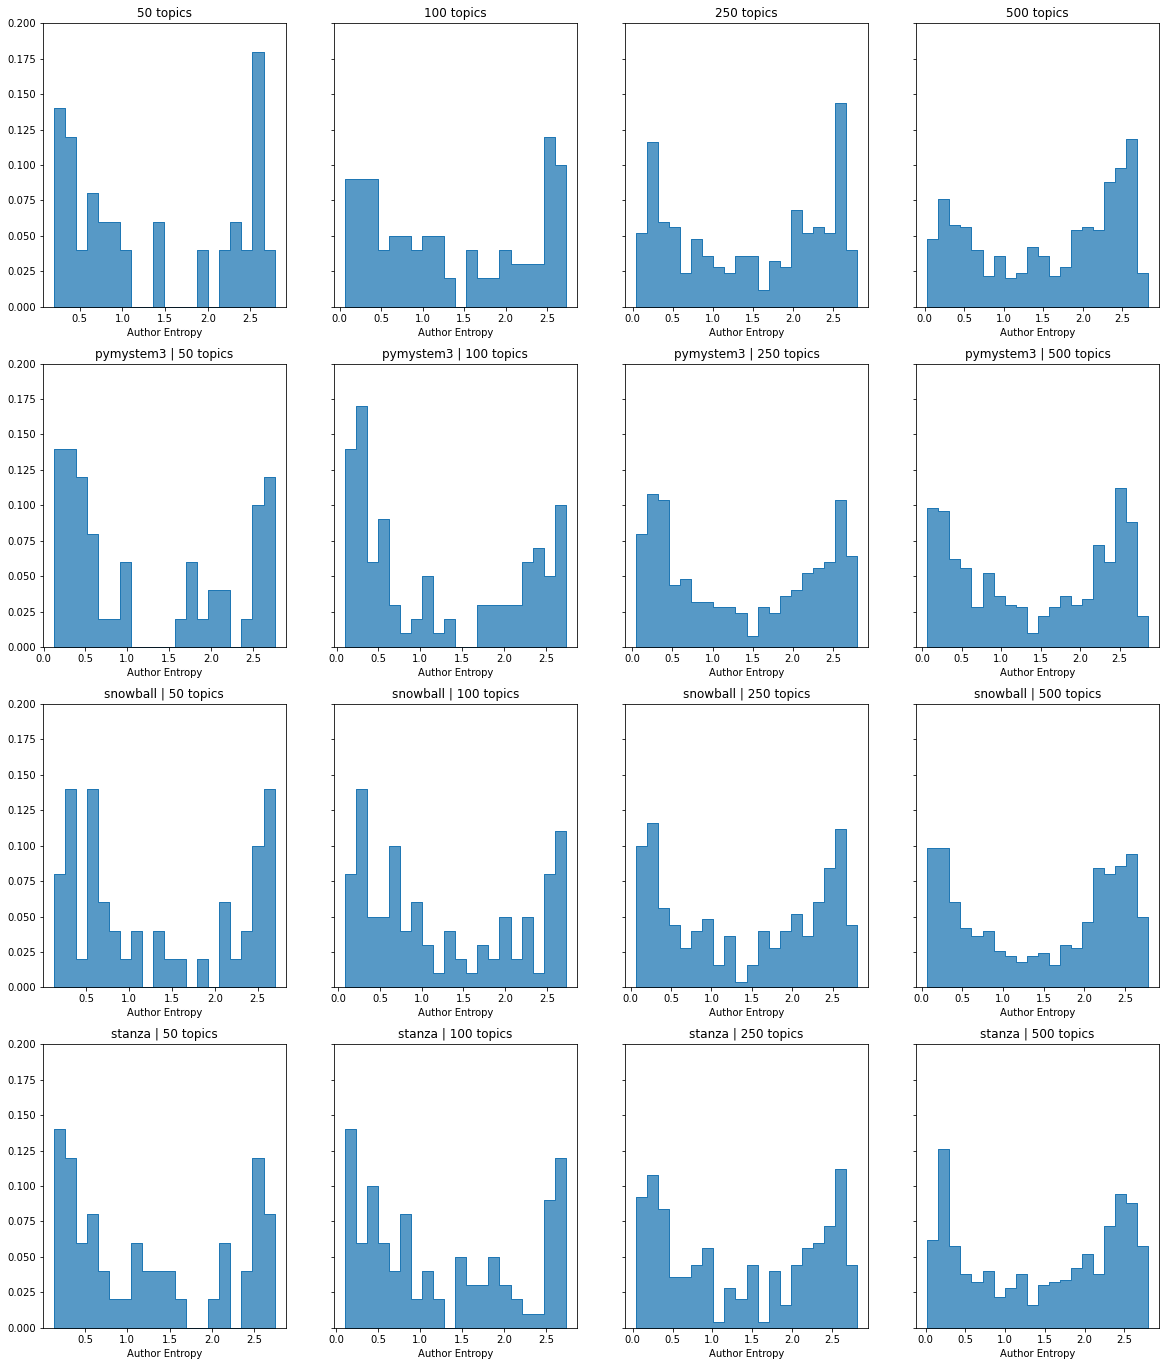

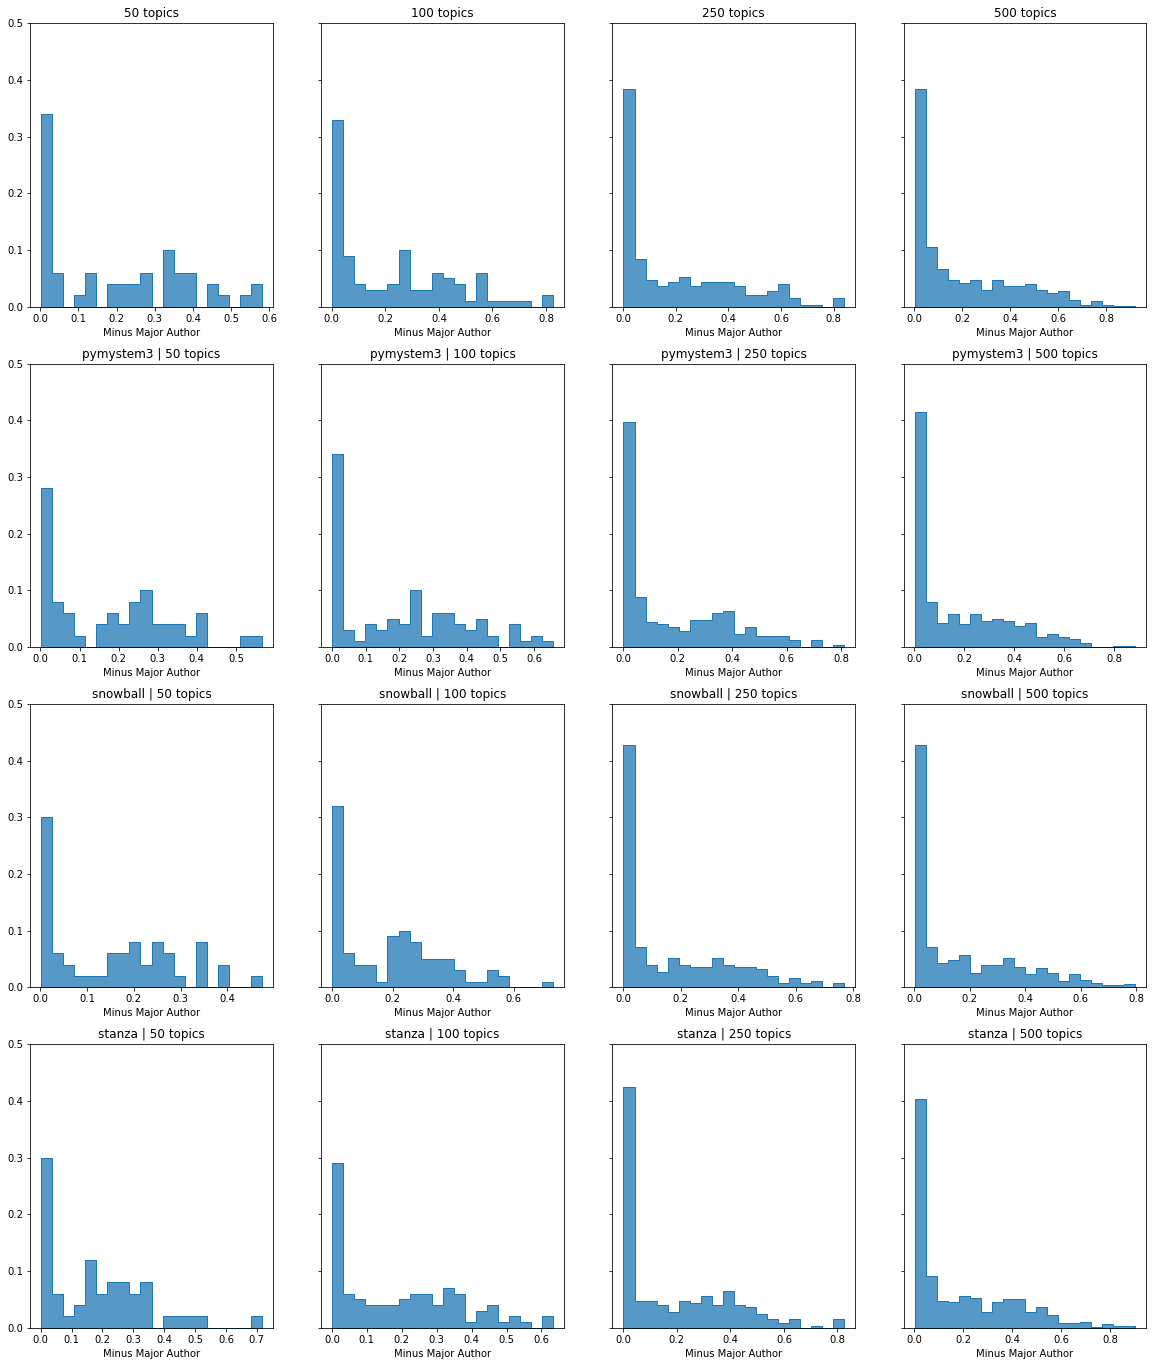

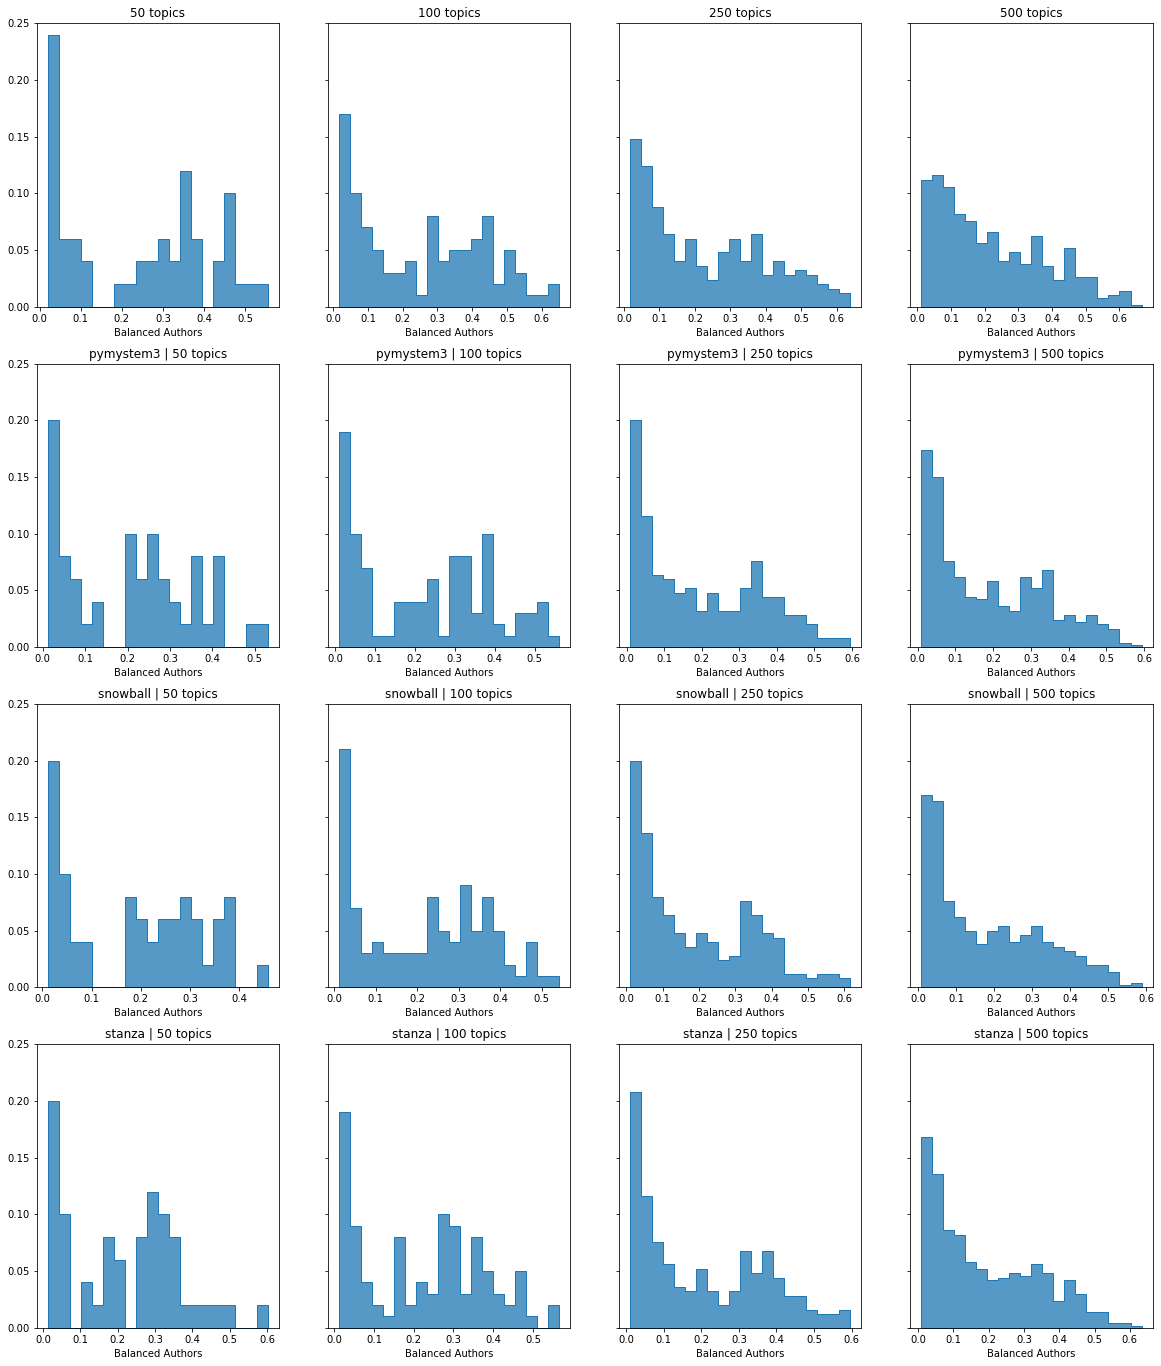

In [33]:

for c in ["Author Entropy", "Minus Major Author", "Balanced Authors"]:
    fig, axs = plt.subplots(ncols=len(NUM_TOPICS), nrows=len(PREPROCESSORS))
    fig.set_figwidth(20)
    fig.set_figheight(24)
    for j in range(len(PREPROCESSORS)):
        p = PREPROCESSORS[j]
        for i in range(len(NUM_TOPICS)):
            n = NUM_TOPICS[i]
            author_data = pd.read_csv(get_path_to_results(n, p, 'author_correlation'), sep='\t', encoding='utf-8', index_col=0)

            tmp = sns.histplot(author_data[c], ax=axs[j][i], bins=20, element='step', stat="probability")
            if p=="":
                tmp.set(title=f"{n} topics")
            else:
                tmp.set(title=f"{p} | {n} topics")
            if c=="Author Entropy":
                max_y=0.2

            elif c=="Balanced Authors":
                max_y=0.25
               
            else:
                max_y=0.5
                #axs[j][i].set_ylim([0, 0.5])

            if i != 0:
                pass
                plt.setp(axs[j][i].get_yticklabels(), visible=False)
            
            axs[j][i].set_ylim([0, max_y])
            axs[j][i].set_ylabel("")
            #axs[j][i].set_yticklabels([f'{f:0.2f}' for f in np.arange(0,max_y, 0.1)])

        plt.savefig(c.replace(" ", ""))

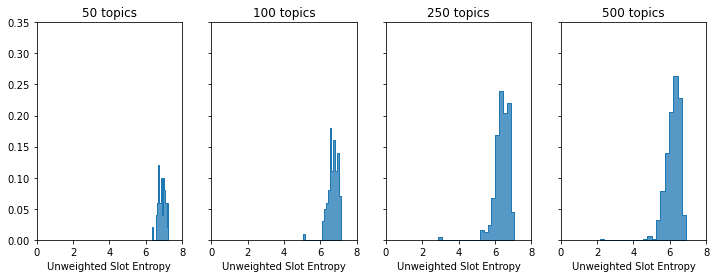

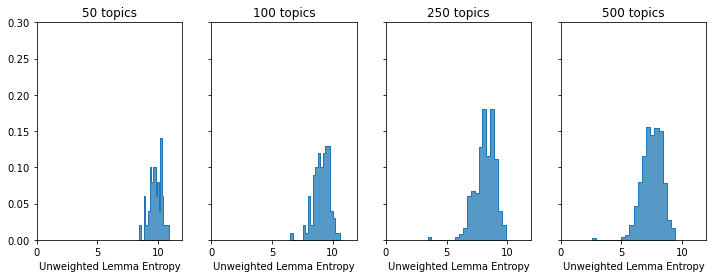

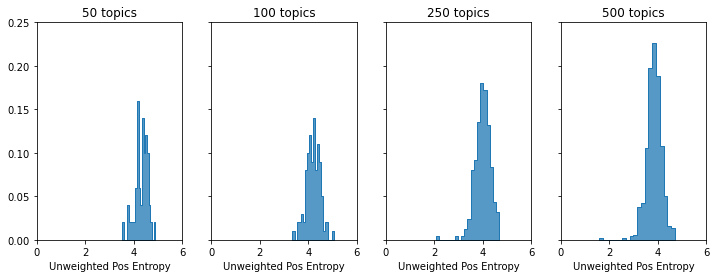

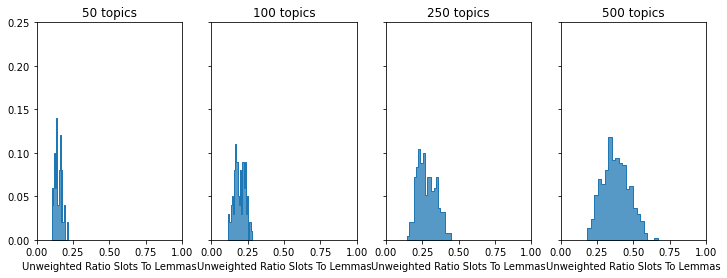

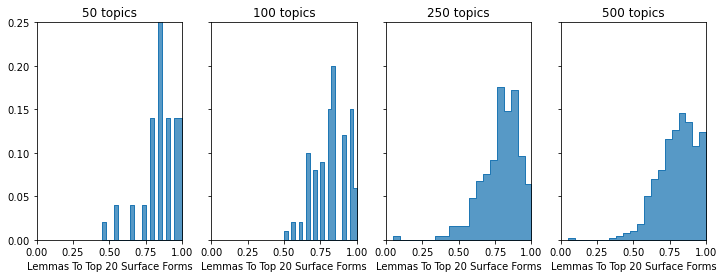

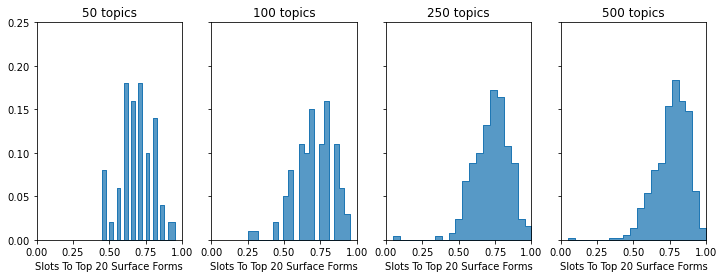

In [25]:
for c in ["unweighted_slot_entropy", "unweighted_lemma_entropy", "unweighted_pos_entropy", 'unweighted_ratio_slots_to_lemmas', 'lemmas_to_top_20_surface_forms', 'slots_to_top_20_surface_forms' ]:
    fig, axs = plt.subplots(ncols=len(NUM_TOPICS))
    fig.set_figwidth(12)
    #fig.set_figheight(12)
    #for j in range(len(PREPROCESSORS)):
        #p = PREPROCESSORS[j]
    for i in range(len(NUM_TOPICS)):
        n = NUM_TOPICS[i]
        data = pd.read_csv(get_path_to_results(n, "", 'entropy'), sep='\t', encoding='utf-8', index_col=0)


        #tmp = sns.histplot(data[c], ax=axs[i], bins=20, element='step', stat="probability")
        tmp.set(title=f"{n} topics", xlabel=c.replace("_"," ").title())
        if c=="unweighted_slot_entropy":
            max_x=8
            max_y=0.35
        elif c=="unweighted_lemma_entropy":
            max_x=12
            max_y=0.3       
        elif c in ["unweighted_ratio_slots_to_lemmas", "lemmas_to_top_20_surface_forms", "slots_to_top_20_surface_forms"]:
            max_x=1
        else:
            max_x=6
            max_y=0.25
            #axs[j][i].set_ylim([0, 0.5])

        if i != 0:
            pass
            plt.setp(axs[i].get_yticklabels(), visible=False)
            
        axs[i].set_ylim([0, max_y])
        axs[i].set_xlim([0, max_x])
        axs[i].set_ylabel("")
        #axs[j][i].set_yticklabels([f'{f:0.2f}' for f in np.arange(0,max_y, 0.1)])

    plt.savefig(c.replace(" ", ""))

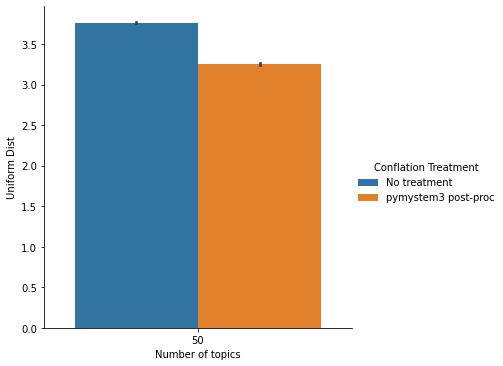

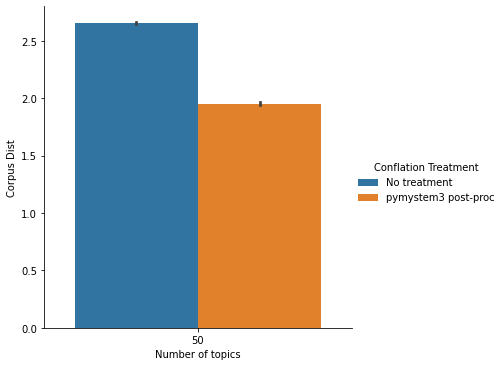

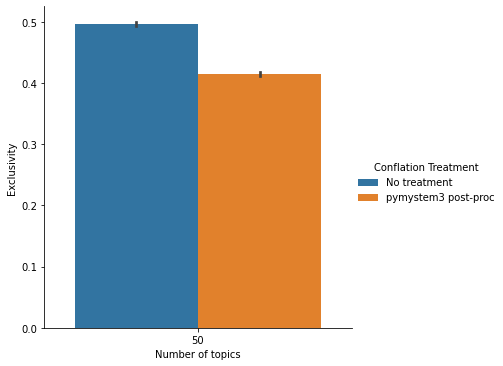

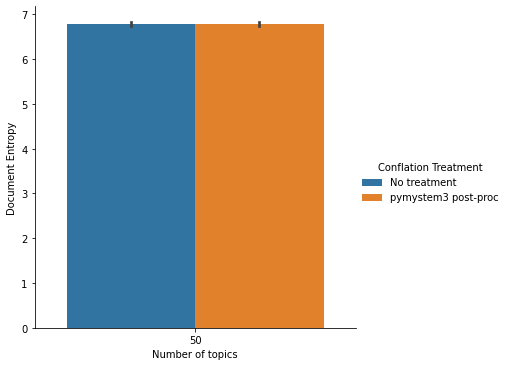

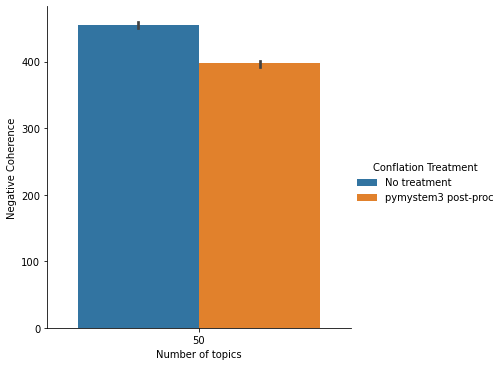

In [21]:
diagnostics_files = {}

for i in NUM_TOPICS:
    results_files = defaultdict(list)
    for count in range(NUM_EXPERIMENTS):
        for p in PREPROCESSORS:
            if p=="":
                k = "No treatment"
            else:
                k = f"{p} pre-proc"
            results_files[k].append(get_path_to_results(i, p, 'diagnostics', False, count))
        results_files["pymystem3 post-proc"].append(get_path_to_results(i, p, 'diagnostics', True, count))
        diagnostics_files[i] = results_files

# coherence and other diagnostics
plot_results = {}
metric_keys = ['uniform_dist', 'corpus_dist', 'exclusivity', 'document_entropy']
plot_data = {'negative_coherence':[], "uniform_dist":[], "corpus_dist":[], "exclusivity":[], "Conflation Treatment":[], "document_entropy":[], "num_topics":[]}
for i in NUM_TOPICS:
    results_files = diagnostics_files[i]
    for k,v_list in results_files.items():
        for v in v_list:
            diagnostics_data = pd.read_csv(v, sep='\t', encoding='utf-8', index_col=0)
            plot_data['Conflation Treatment'].append(k)
            plot_data['num_topics'].append(str(i))
            plot_data['negative_coherence'].append(-np.mean(diagnostics_data["coherence"]))
            for m in metric_keys:
                plot_data[m].append(np.mean(diagnostics_data[m]))

plot_df = pd.DataFrame.from_dict(plot_data)
for m in metric_keys + ['negative_coherence']:
    tmp = sns.catplot(data = plot_df, kind="bar", x="num_topics", y=m, hue="Conflation Treatment")
    tmp.set_axis_labels("Number of topics", m.replace("_", " ").title())
    plt.savefig(f"{m}.png")
    


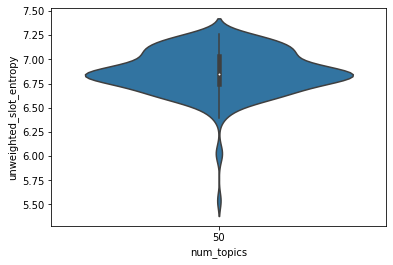

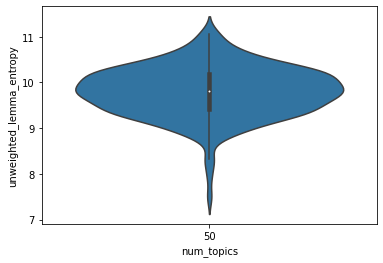

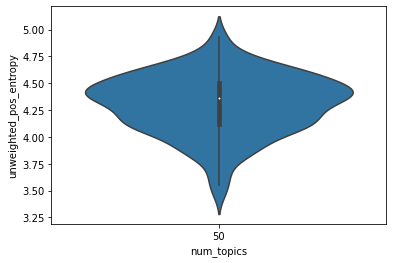

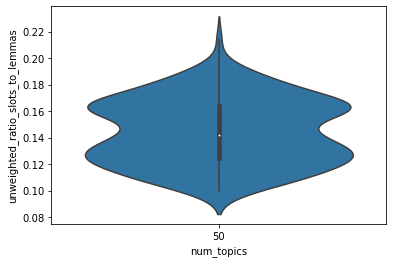

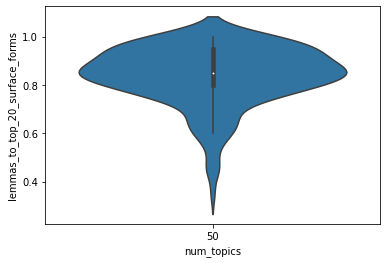

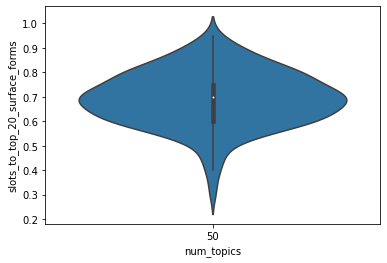

In [39]:
ent_files = {}

for i in NUM_TOPICS:
    results_files = defaultdict(list)
    for count in range(NUM_EXPERIMENTS):
        results_files[k].append(get_path_to_results(i, "", 'entropy', False, count))
        ent_files[i] = results_files

# coherence and other diagnostics
plot_results = {}

metric_keys = ["unweighted_slot_entropy", "unweighted_lemma_entropy", "unweighted_pos_entropy", 'unweighted_ratio_slots_to_lemmas', 'lemmas_to_top_20_surface_forms', 'slots_to_top_20_surface_forms' ]
plot_data = defaultdict(list)
for i in NUM_TOPICS:
    results_files = ent_files[i]
    for k,v_list in results_files.items():
        for v in v_list:
            ent_data = pd.read_csv(v, sep='\t', encoding='utf-8', index_col=0)
            plot_data['Number of topics'].extend([str(i)]*len(ent_data))
            for m in metric_keys:
                plot_data[m].extend((list(ent_data[m])))

plot_df = pd.DataFrame.from_dict(plot_data)
for m in metric_keys:
    plt.figure()
    tmp = sns.violinplot(data = plot_df, x="Number of topics", y=m)
    #tmp.set_axis_labels("Number of topics", m.replace("_", " ").title())
    plt.savefig(f"{m}.png")